In [1]:
# Импорт модулей, не связанныех с PySpark.
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# Это помогает автоматически распечатывать элементы без явного использования «печати».
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
# Импорт модулей, связанных с PySpark.
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, mean
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Инициализировать сеанс Spark.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'data/automatic_weather_stations_inmet_brazil_2000_2021.csv' # Загрузите данные в текущий каталог Colab.
# Загрузите основной набор данных в фрейм данных pyspark.
df = spark.read.csv(filename_data, header=True, inferSchema=True, sep=';')
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


Данные для анализа: Метеорологические данные Бразилии, которые были получены при помощи автоматических станциях.

In [3]:
columns_to_read = ["ESTACAO", "DATA (YYYY-MM-DD)", "HORA (UTC)", "PRECIPITACAO TOTAL HORARIO (mm)", "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",
                  "TEMPERATURA DO AR - BULBO SECO, HORARIA (C)"]

print('Обзор данных')
df.printSchema()
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор данных
root
 |-- ESTACAO: string (nullable = true)
 |-- DATA (YYYY-MM-DD): date (nullable = true)
 |-- HORA (UTC): integer (nullable = true)
 |-- PRECIPITACAO TOTAL HORARIO (mm): double (nullable = true)
 |-- PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB): double (nullable = true)
 |-- PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB): double (nullable = true)
 |-- PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB): double (nullable = true)
 |-- RADIACAO GLOBAL (W/m2): double (nullable = true)
 |-- TEMPERATURA DO AR - BULBO SECO, HORARIA (C): double (nullable = true)
 |-- TEMPERATURA DO PONTO DE ORVALHO (C): double (nullable = true)
 |-- TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C): double (nullable = true)
 |-- TEMPERATURA MINIMA NA HORA ANT. (AUT) (C): double (nullable = true)
 |-- TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C): double (nullable = true)
 |-- TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C): double (nullable = true)
 |-- UMIDADE REL. MAX. NA HORA ANT. (AUT) (%):

,Column Name,Data type
0,ESTACAO,string
1,DATA (YYYY-MM-DD),date
2,HORA (UTC),int
3,PRECIPITACAO TOTAL HORARIO (mm),double
4,"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORAR...",double
5,PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),double
6,PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),double
7,RADIACAO GLOBAL (W/m2),double
8,"TEMPERATURA DO AR - BULBO SECO, HORARIA (C)",double
9,TEMPERATURA DO PONTO DE ORVALHO (C),double


Для удобства и сбережения времени, которое затрачивается на обработку, были оставлены только выборочные колонки.
1) ESTACAO – Код станции, фиксировавшей данные
2) DATA (YYYY-MM-DD) – Дата фиксации показателей
3) HORA (UTC) – Час, в которой фиксировались показатели
4) PRECIPITACAO TOTAL HORARIO (mm) – Количество осадков, выпавших за час
5) PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB) – Атмосферное давление на уровне станции 6) TEMPERATURA DO AR - BULBO SECO, HORARIA (C) – Температура воздуха

In [4]:
df = df.select(*columns_to_read)
numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, (DoubleType))]
numeric_columns.remove("PRECIPITACAO TOTAL HORARIO (mm)")

for col in numeric_columns:
    avg_value = df.select(mean(col)).collect()[0][0]
    df = df.fillna({col: avg_value})

df = df.dropna(subset=["ESTACAO", "DATA (YYYY-MM-DD)", "HORA (UTC)"])
df.show()

+-------+-----------------+----------+-------------------------------+-----------------------------------------------------+-------------------------------------------+
|ESTACAO|DATA (YYYY-MM-DD)|HORA (UTC)|PRECIPITACAO TOTAL HORARIO (mm)|PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)|TEMPERATURA DO AR - BULBO SECO, HORARIA (C)|
+-------+-----------------+----------+-------------------------------+-----------------------------------------------------+-------------------------------------------+
|   A001|       2021-01-01|         0|                            0.0|                                                887.1|                                       20.9|
|   A001|       2021-01-01|       100|                            0.0|                                                887.3|                                       20.5|
|   A001|       2021-01-01|       200|                            0.0|                                                887.9|                               

Замена выбросов на границы квартилей.

In [5]:
def replace_outliers(df, column):
  
    median_value = df.approxQuantile(column, [0.5], 0.05)[0]
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    
    if len(quantiles) < 2 or quantiles[0] is None or quantiles[1] is None:
        print(f"Skipping {column}: insufficient data for quantiles")
        return df

    iqr = quantiles[1] - quantiles[0]
    lower_bound = median_value - 1.5 * iqr
    upper_bound = median_value + 1.5 * iqr
    print(f"{column}: Lower bound={lower_bound}, Upper bound={upper_bound}")
    
    # Замена выбросов на границы
    df = df.withColumn(
        column,
        F.when(F.col(column) < lower_bound, lower_bound)
         .when(F.col(column) > upper_bound, upper_bound)
         .otherwise(F.col(column))
    )
    
    return df



In [6]:

for col in numeric_columns:
    df = replace_outliers(df, col)  # Или используйте другой метод


PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB): Lower bound=861.3499999999999, Upper bound=1068.65
TEMPERATURA DO AR - BULBO SECO, HORARIA (C): Lower bound=10.649999999999999, Upper bound=34.95


In [7]:

df.show()


+-------+-----------------+----------+-------------------------------+-----------------------------------------------------+-------------------------------------------+
|ESTACAO|DATA (YYYY-MM-DD)|HORA (UTC)|PRECIPITACAO TOTAL HORARIO (mm)|PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)|TEMPERATURA DO AR - BULBO SECO, HORARIA (C)|
+-------+-----------------+----------+-------------------------------+-----------------------------------------------------+-------------------------------------------+
|   A001|       2021-01-01|         0|                            0.0|                                                887.1|                                       20.9|
|   A001|       2021-01-01|       100|                            0.0|                                                887.3|                                       20.5|
|   A001|       2021-01-01|       200|                            0.0|                                                887.9|                               

Получение статистических показателей

In [8]:
statistics = {}

for col in numeric_columns:
    mean_value = df.agg(F.mean(col)).collect()[0][0]
    stddev_value = df.agg(F.stddev(col)).collect()[0][0]
    quantiles = df.approxQuantile(col, [0.25, 0.5, 0.75], 0.05)
    min_value = df.agg(F.min(col)).collect()[0][0]
    max_value = df.agg(F.max(col)).collect()[0][0]
    
    statistics[col] = {
        'mean': mean_value,
        'stddev': stddev_value,
        'min': min_value,
        'max': max_value,
        '25%': quantiles[0],
        '50%': quantiles[1],
        '75%': quantiles[2],
    }

statistics_df = spark.createDataFrame(
    [(col, stat['mean'], stat['stddev'], stat['min'], stat['max'], stat['25%'], stat['50%'], stat['75%']) for col, stat in statistics.items()],
    ['Column', 'Mean', 'StdDev', 'Min', 'Max', '25th Percentile', '50th Percentile (Median)', '75th Percentile']
)

statistics_df.show(truncate=False)


+-----------------------------------------------------+------------------+------------------+------------------+------+---------------+------------------------+---------------+
|Column                                               |Mean              |StdDev            |Min               |Max   |25th Percentile|50th Percentile (Median)|75th Percentile|
+-----------------------------------------------------+------------------+------------------+------------------+------+---------------+------------------------+---------------+
|PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)|955.0942501320393 |47.46402146375752 |861.3499999999999 |1050.0|923.9          |965.0                   |993.0          |
|TEMPERATURA DO AR - BULBO SECO, HORARIA (C)          |22.159640582973477|6.3996596033476445|10.649999999999999|34.95 |18.2           |22.8                    |26.3           |
+-----------------------------------------------------+------------------+------------------+------------------+---

Построение матрицы корреляции между признаками

<Figure size 1000x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Матрица корреляций между признаками')

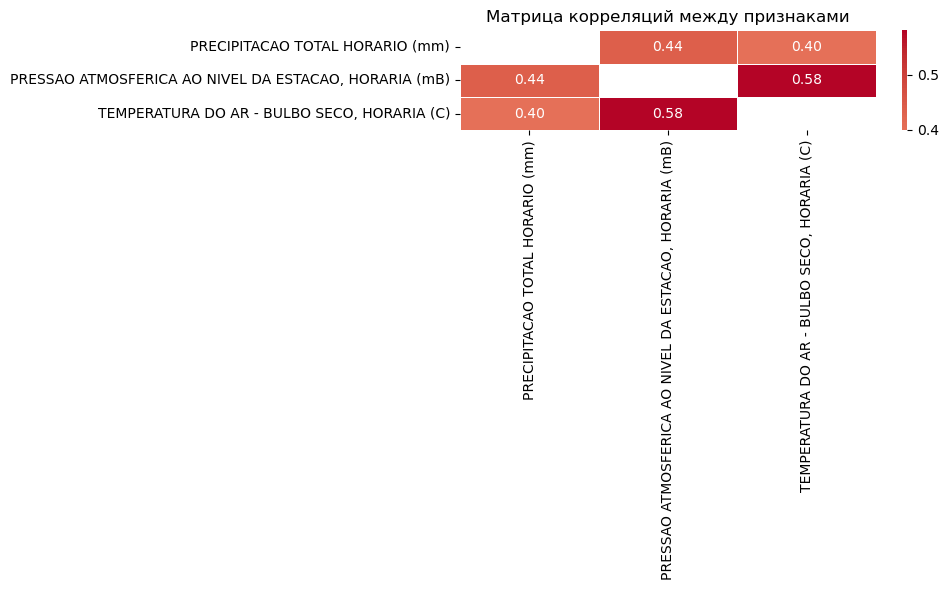

In [13]:
correlation_matrix = {}
numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, (DoubleType))]

numeric_columns.sort() 

for col1 in numeric_columns:
    correlation_matrix[col1] = {}
    for col2 in numeric_columns:
        if col1 != col2:
            correlation_matrix[col1][col2] = df.stat.corr(col1, col2)

import pandas as pd
corr_df = pd.DataFrame(correlation_matrix)

corr_df = corr_df.reindex(sorted(corr_df.columns), axis=1)
corr_df = corr_df.reindex(sorted(corr_df.columns), axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляций между признаками')
plt.tight_layout()
plt.show()


Выводы: 
Между осадками и атмосферным давлением имеется положительная корреляция в размере 0.44. Это означает, что изменения в одном признаке сопровождаются изменениями в другом признаке на умеренном уровне. Между осадками и температурой также существует положительная корреляция в размере 0.4. Это говорит о том, что изменения в этих признаках идут в одном направлении и не сильно связаны между собой. Между давлением и температурой самый большой уровень корреляции – 0.58. Это указывает на наличие довольно сильной связи между этими признаками.

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='DATA (YYYY-MM-DD)', ylabel='Avg_Temperatura'>

Text(0.5, 1.0, 'Средние значения параметров по датам')

Text(0.5, 0, 'Дата')

Text(0, 0.5, 'Средние значения')

(array([ 9496., 10957., 12418., 13879., 15340., 16801., 18262., 19723.]),
 [Text(9496.0, 0, '1996'),
  Text(10957.0, 0, '2000'),
  Text(12418.0, 0, '2004'),
  Text(13879.0, 0, '2008'),
  Text(15340.0, 0, '2012'),
  Text(16801.0, 0, '2016'),
  Text(18262.0, 0, '2020'),
  Text(19723.0, 0, '2024')])

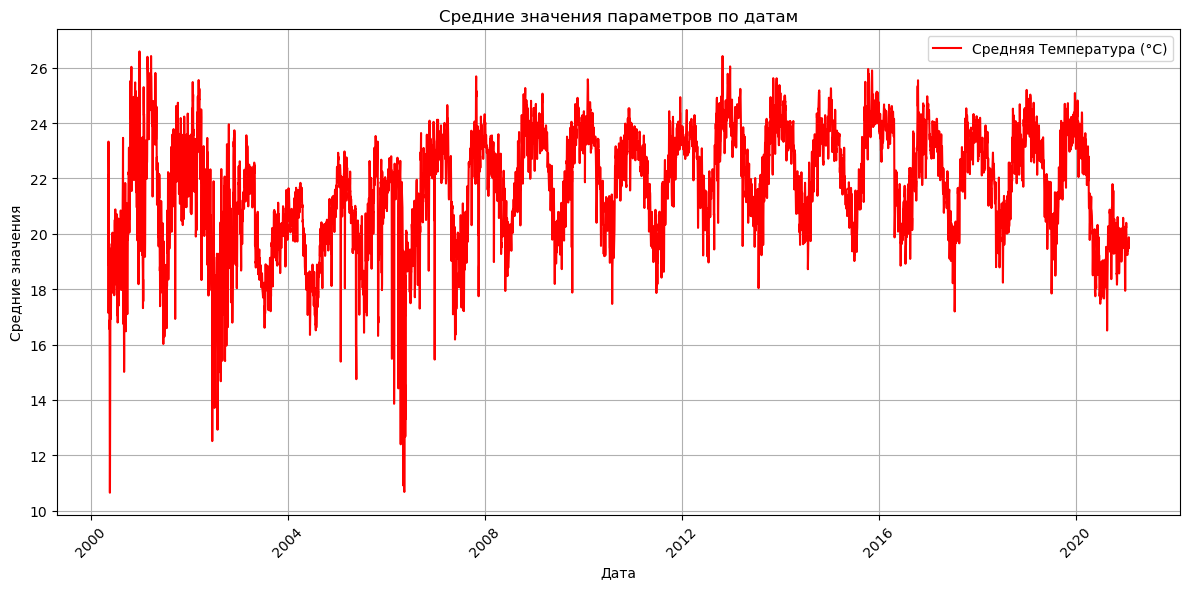

In [10]:
# Вычисляем средние значения для каждого столбца по дате
df_avg = df.groupBy('DATA (YYYY-MM-DD)').agg(
    F.avg('TEMPERATURA DO AR - BULBO SECO, HORARIA (C)').alias('Avg_Temperatura')
)

df_avg_pd = df_avg.toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_avg_pd, x='DATA (YYYY-MM-DD)', y='Avg_Temperatura', label='Средняя Температура (°C)', color='red')

plt.title('Средние значения параметров по датам')
plt.xlabel('Дата')
plt.ylabel('Средние значения')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='DATA (YYYY-MM-DD)', ylabel='Avg_Pressao'>

Text(0.5, 1.0, 'Средние значения параметров по датам')

Text(0.5, 0, 'Дата')

Text(0, 0.5, 'Средние значения')

(array([ 9496., 10957., 12418., 13879., 15340., 16801., 18262., 19723.]),
 [Text(9496.0, 0, '1996'),
  Text(10957.0, 0, '2000'),
  Text(12418.0, 0, '2004'),
  Text(13879.0, 0, '2008'),
  Text(15340.0, 0, '2012'),
  Text(16801.0, 0, '2016'),
  Text(18262.0, 0, '2020'),
  Text(19723.0, 0, '2024')])

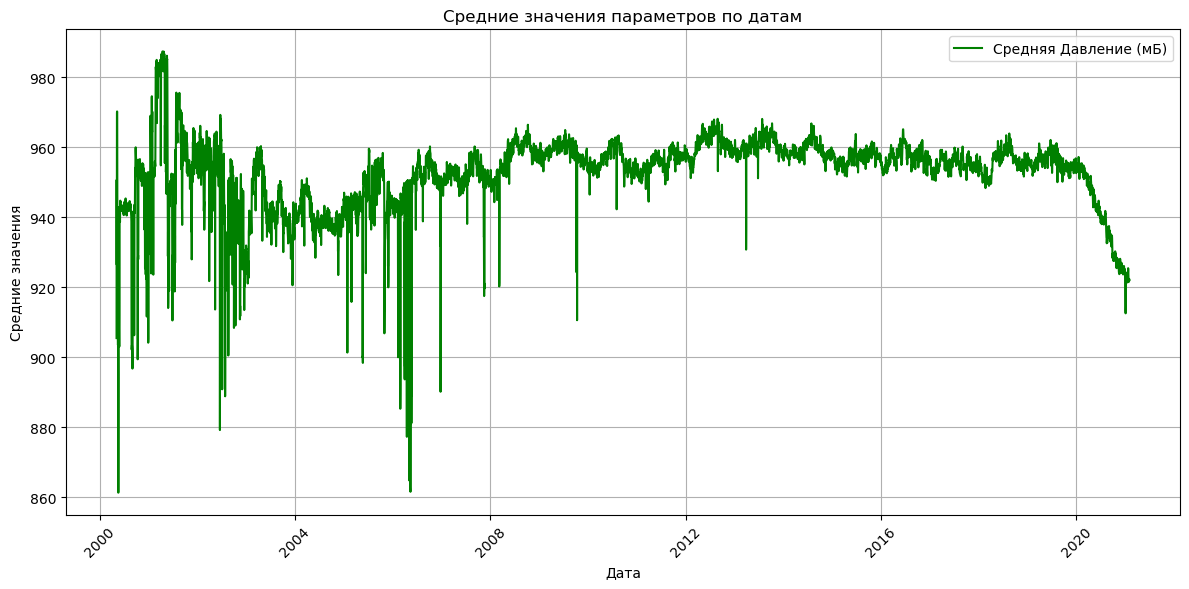

In [11]:
# Вычисляем средние значения для каждого столбца по дате
df_avg = df.groupBy('DATA (YYYY-MM-DD)').agg(
    F.avg('PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)').alias('Avg_Pressao')
)

df_avg_pd = df_avg.toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_avg_pd, x='DATA (YYYY-MM-DD)', y='Avg_Pressao', label='Среднее давление (мБ)', color='green')

plt.title('Средние значения параметров по датам')
plt.xlabel('Дата')
plt.ylabel('Средние значения')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

По графику средней температуры видно, что температура циклична и по графику можно наблюдать явную сезонность, чего нельзя явно сказать про давление. Давление не зависит от даты, поэтому график достаточно хаотичен. 